In [1]:
import requests
import pandas as pd
import logging
import numpy as np
from IPython.display import Image
from sklearn.utils.class_weight import compute_class_weight
import joblib
import re

from config import DATA, EVALUATION, ENCODER
from utils import *
from preprocessing import LabelEncoderWrapper

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', 50)

# SNP Selection

Study (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3694299/) shows: 8-plex system suited for eye-color prediction tasks 
rs12896399 at SLC24A4, rs12913832 at HERC2, rs1545397 at OCA2, rs16891982 at SLC45A2, rs1426654 at SLC24A5, rs885479 at MC1R, rs6119471 at ASIP, and rs12203592 at IRF4. Below one can find some basic information on the selected SNP.

In [2]:
# Load the annotations
df_annotations = pd.read_csv(DATA['ANNOTATIONS'])
df_annotations

,rs12896399,rs12913832,rs1545397,rs16891982,rs1426654,rs885479,rs6119471,rs12203592
0,rs12896399,rs12913832,rs1545397,rs16891982,rs1426654,rs885479,rs6119471,rs12203592
1,14,15,15,5,15,16,20,6
2,92307319,28120472,28187772,33951588,48134287,89919746,32785212,396321
3,"{'A': 16, 'T': 2724, 'G': 4026, 'C': 0}","{'A': 2351, 'T': 0, 'G': 4347, 'C': 0}","{'A': 4, 'T': 0, 'G': 0, 'C': 0}","{'A': 0, 'T': 0, 'G': 5508, 'C': 900}","{'A': 6499, 'T': 0, 'G': 483, 'C': 0}","{'A': 528, 'T': 0, 'G': 6292, 'C': 14, '-': 4}","{'A': 0, 'T': 0, 'G': 0, 'C': 0}","{'A': 0, 'T': 977, 'G': 0, 'C': 5749}"
4,"{'GT': 1544, 'GG': 1241, 'TT': 590, 'AA': 8}","{'GG': 1548, 'AG': 1251, 'AA': 550}",{'AA': 2},"{'GG': 2549, 'CG': 410, 'CC': 245}","{'AA': 3140, 'AG': 219, 'GG': 132}","{'GG': 2924, 'AG': 444, 'CC': 7, 'AA': 42, '--...",{},"{'CC': 2483, 'CT': 783, 'TT': 97}"
5,{'mendeley': [{'author': 'Kornkiat Vongpaisarn...,"{'mendeley': [{'author': 'Melissa Edwards', 't...","{'mendeley': [], 'plos': [], 'snpedia': [], 'p...","{'mendeley': [{'author': 'Jonas Mengel-From', ...",{'mendeley': [{'author': 'Chandana Basu Mallic...,"{'mendeley': [], 'plos': [{'author': 'Sophie I...","{'mendeley': [], 'plos': [], 'snpedia': [], 'p...","{'mendeley': [{'author': 'Jiali Han', 'title':..."


# Phenotype data

In [3]:
df_phen = pd.read_csv(DATA['PHEN'])
df_phen.head()

,id,characteristic,known_variations,number_of_users,number_variations
0,1,Eye color,"['Brown', 'Brown-green', 'Blue-green', 'Blue-g...",1804,54
1,3,Handedness,"['Right-handed', 'Left-handed', 'Ambidexterous...",1539,34
2,60,Sex,"['Male', 'Female', 'Man', 'Woman', 'Transgende...",1382,15
3,15,Height,"['Tall ( >180cm )', '188cm', '6\'3""', 'Average...",1379,113
4,13,Hair Color,"['Auburn (reddish-brown)', 'Blonde', 'Dirt-bro...",952,50


Chose eye color as phenotype target as it yields most data points (1804) and high heritability (ca. 80%) (https://pubmed.ncbi.nlm.nih.gov/623434/#:~:text=The%20estimates%20of%20heritability%20are,0.80%20(eye%2Dcolour))

In [4]:
variations = df_phen['known_variations'].iloc[0]
variations_list = re.findall(r"'(.*?)'", variations)

print(f"There are {len(variations_list)} eye color variations in the dataset")
print(f"Eye color variations: {variations_list}")

There are 54 eye color variations in the dataset
Eye color variations: ['Brown', 'Brown-green', 'Blue-green', 'Blue-grey', 'Green', 'Blue', 'Hazel (brown/green)', 'Hazel', 'Mixed', 'Light-mixed green', 'Dark blue', 'Dark brown', 'Blue-green ', 'Hazel/light brown', 'Braun', 'Gray-blue', 'Green-brown', 'Indeterminate brown-green with a subtle grey caste', 'Blue-grey; broken amber collarette', 'Blue grey', 'Rs12913832 aa', 'Brown-(green when external temperature rises)', 'Gg', 'Rs12913832 ag (they', 'Green-gray', 'Grey brown', 'Blue with yellow parts', 'Olive-brown ringing burnt umber-brown', 'Ambar-green', 'Blue-green; amber collarette, and gray-blue ringing', 'Green-hazel', 'Brown - brown and green in bright sunlight', 'Light blue-green', 'Unknown', 'Blue, grey, green, changing', 'Split - one side dark blue / other side light blue and green', 'Blue-green-grey', 'Blue-brown heterochromia', 'Dark grayish-blue eyes (like a stone)', 'Brown/black', 'Blue with a yellow ring of flecks that mak

In [5]:
df_user = pd.read_csv(DATA['USER'])
no_new = df_user["variation"].nunique()
print(f"After mapping there remain {no_new} unique eye color variations")
print(f"Eye color variations: {df_user['variation'].unique()}")

After mapping there remain 9 unique eye color variations
Eye color variations: ['Brown' 'Brown-Green' 'Blue-Green' 'Blue-Grey' 'Green' 'Blue' 'Hazel'
 'Mixed' 'Grey']


# Genotype data

In [6]:
df_gen = pd.read_csv(DATA["GEN"])
df_gen.head()

,user_name,user_id,rs12896399,rs12913832,rs1545397,rs16891982,rs1426654,rs885479,rs6119471,rs12203592
0,R.M. Holston,22,GT,GG,GG,AA,GG,CC,NaN,NaN
1,Charles G. Sullivan,5326,GT,GG,GG,AA,GG,TT,NaN,NaN
2,Angel Harris,495,GT,AG,GG,AA,GG,CT,NaN,NaN
3,kevinmcc,285,GT,AG,GG,AA,GG,CC,NaN,NaN
4,Razib Khan,33,GT,AA,CC,AA,GG,CC,NaN,NaN


In [7]:
df_gen.shape[0]

1129

Of the 1803 users who indicated their eye-color, we can find 1129 users with data on at least one of the SNP we are interested in. 

In [8]:
df_encoded = pd.read_csv(DATA["ENCODED"])
df_encoded.head()

,rs12896399,rs12913832,rs1545397,rs16891982,rs1426654,rs885479,rs6119471,rs12203592,eye_color
0,1.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,Green
1,1.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,Blue-Grey
2,1.0,1.0,2.0,2.0,2.0,2.0,NaN,NaN,Green
3,1.0,1.0,2.0,2.0,2.0,2.0,NaN,NaN,Brown
4,1.0,0.0,2.0,2.0,2.0,2.0,NaN,NaN,Brown


We encode the data using a ternary system in which 0 indicating that both maternal and paternal positions match the reference genome, 1 indicating that only maternal or paternal positions match, and 2 indicating that both are alternative variants. The reference alleles has been determined via https://www.ncbi.nlm.nih.gov/snp/?term=rs12913832: <br>
rs12896399: G <br>
rs12913832: A <br>
rs1545397: A  <br>
rs16891982: C <br>
rs1426654: A  <br>
rs885479: G   <br>
rs6119471: C  <br>
rs12203592: C  <br>

# EDA

In [9]:
df_encoded.isna().sum()

rs12896399     141
rs12913832      54
rs1545397      217
rs16891982      14
rs1426654      116
rs885479        53
rs6119471      975
rs12203592    1125
eye_color        0
dtype: int64

As we can see there are still a lot of NaN values in the dataset. The SNP 'rs12203592' has the most NaNs (1125), followed by 'rs6119471' with 975 NaNs. Before deciding to drop these SNPs due to high missing values, let us check if they are significant identifiers for any eye color categories. If they are predictive for certain classes despite the missing data, they might still be valuable for the classification model.

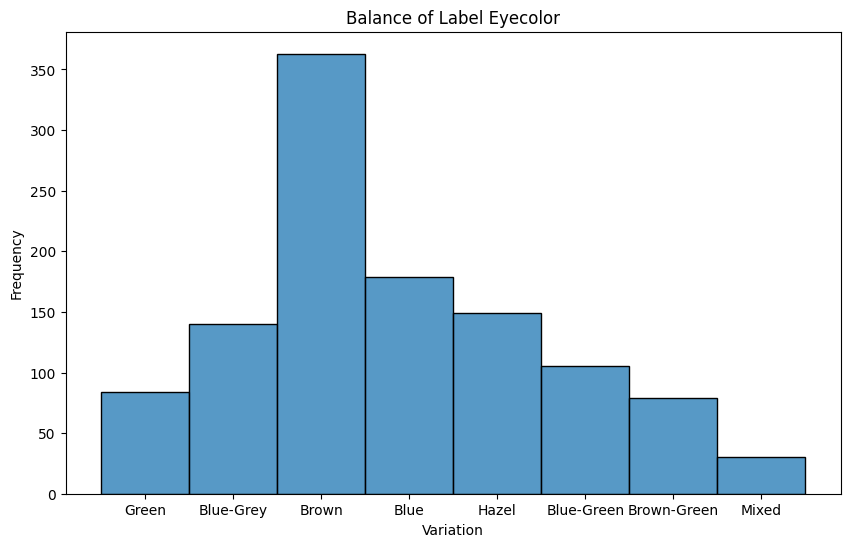

In [39]:
plot_phenotype_distribution(df_encoded, 'eye_color')

The histogram indicates class imbalance with 'Brown' being the most common eye color and 'Mixed' and 'Green' being the least common. For our classification model, this suggests a potential bias towards predicting more common eye colors accurately while less common ones may be underrepresented and thus less accurately predicted. Addressing class imbalance in the model training will be important for robust performance across all eye color categories. Therefore we consider class weighting to balance the dataset. Moreover, we decide to remove Mixed.

In [11]:
class_weights = compute_class_weight('balanced', classes=np.unique(df_encoded["eye_color"]), y=df_encoded["eye_color"])
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print(class_weights_dict)

{0: 0.7884078212290503, 1: 1.3440476190476192, 2: 1.0080357142857144, 3: 0.38877410468319556, 4: 1.7863924050632911, 5: 1.6800595238095237, 6: 0.9471476510067114, 7: 4.704166666666667}


These are the weights that each class should be assigned to balance the dataset

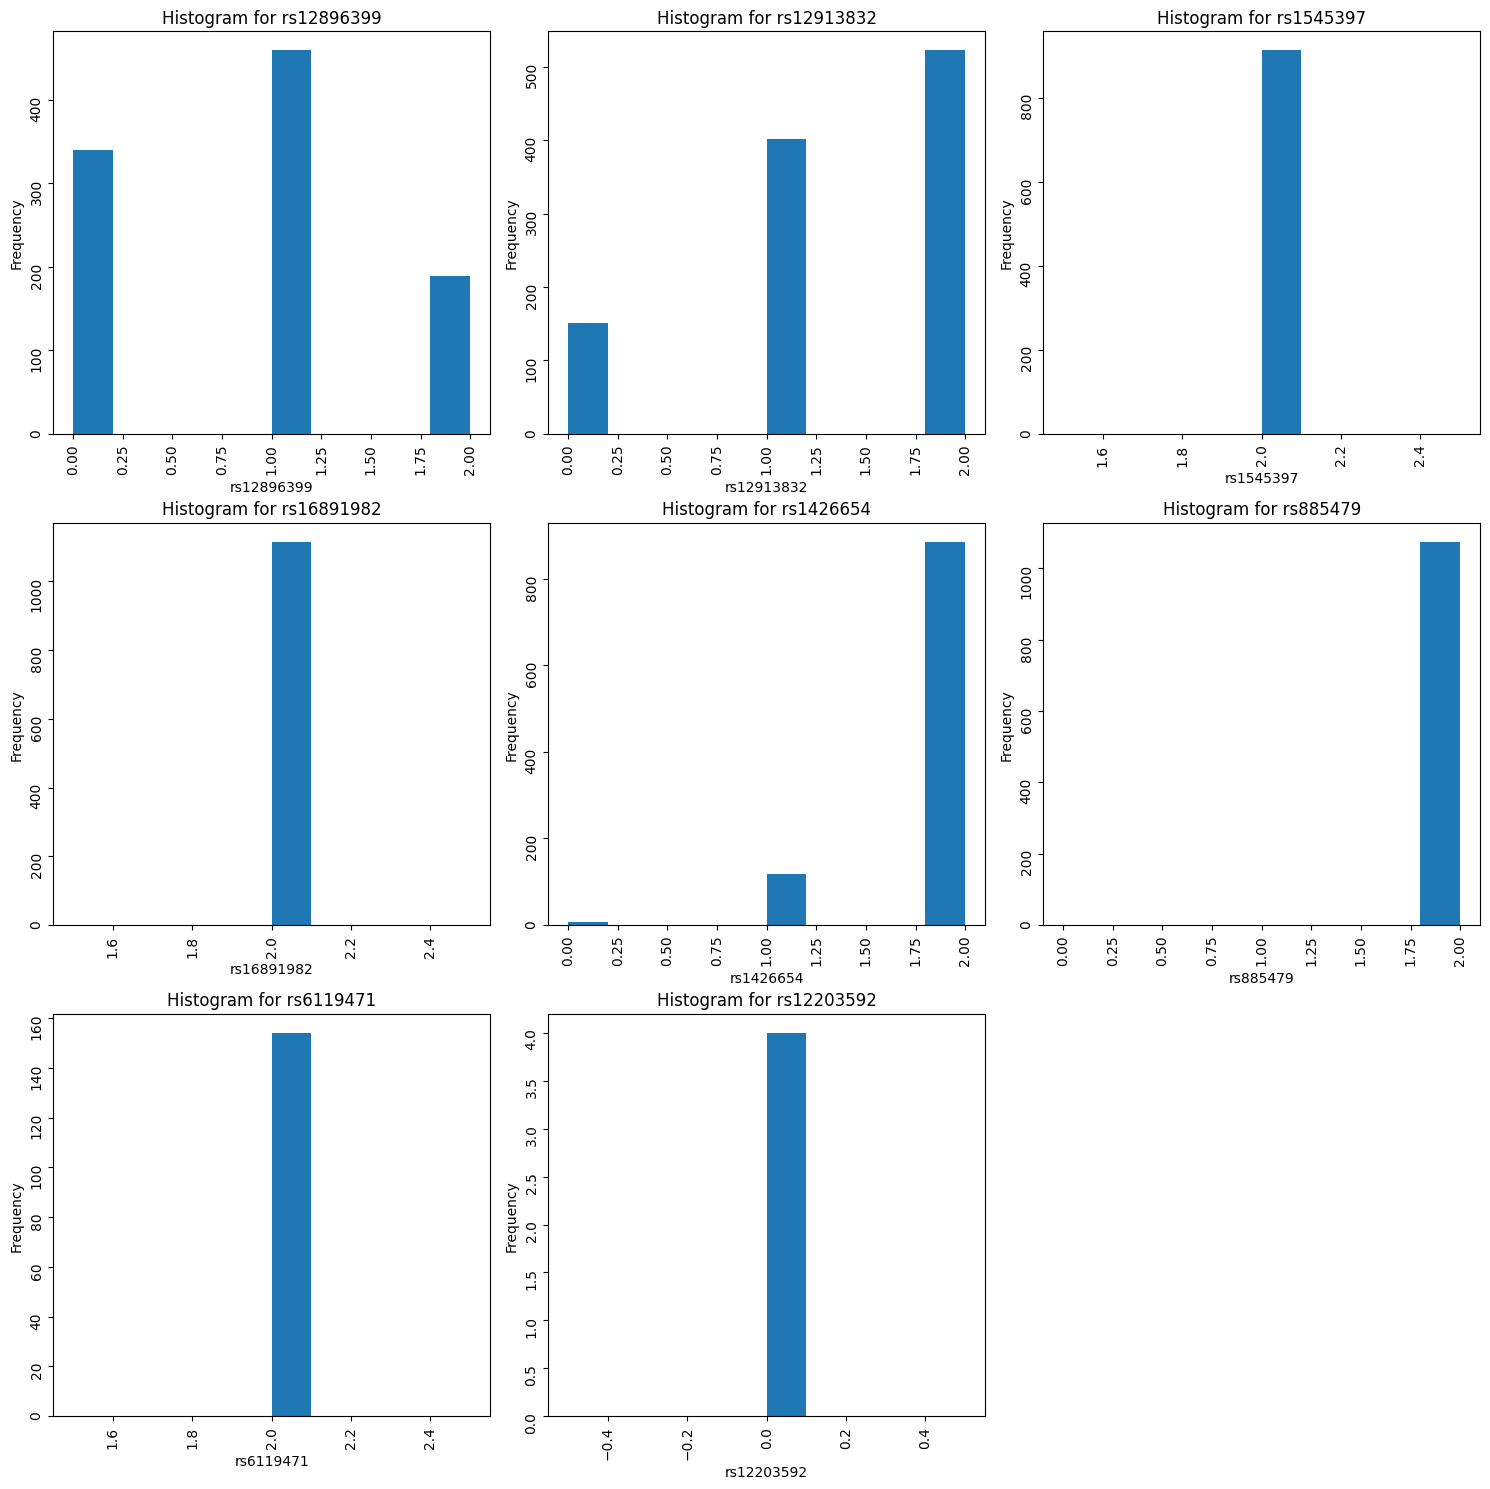

In [12]:
plot_rsin(df_encoded)


The histograms for each SNP show varying levels of genotype frequencies. Some SNPs exhibit a highly skewed distribution towards a single genotype, which might be less informative for classification unless there's a strong link to a phenotype. SNPs with more evenly distributed genotypes could be more useful for the model to differentiate between phenotypes. 

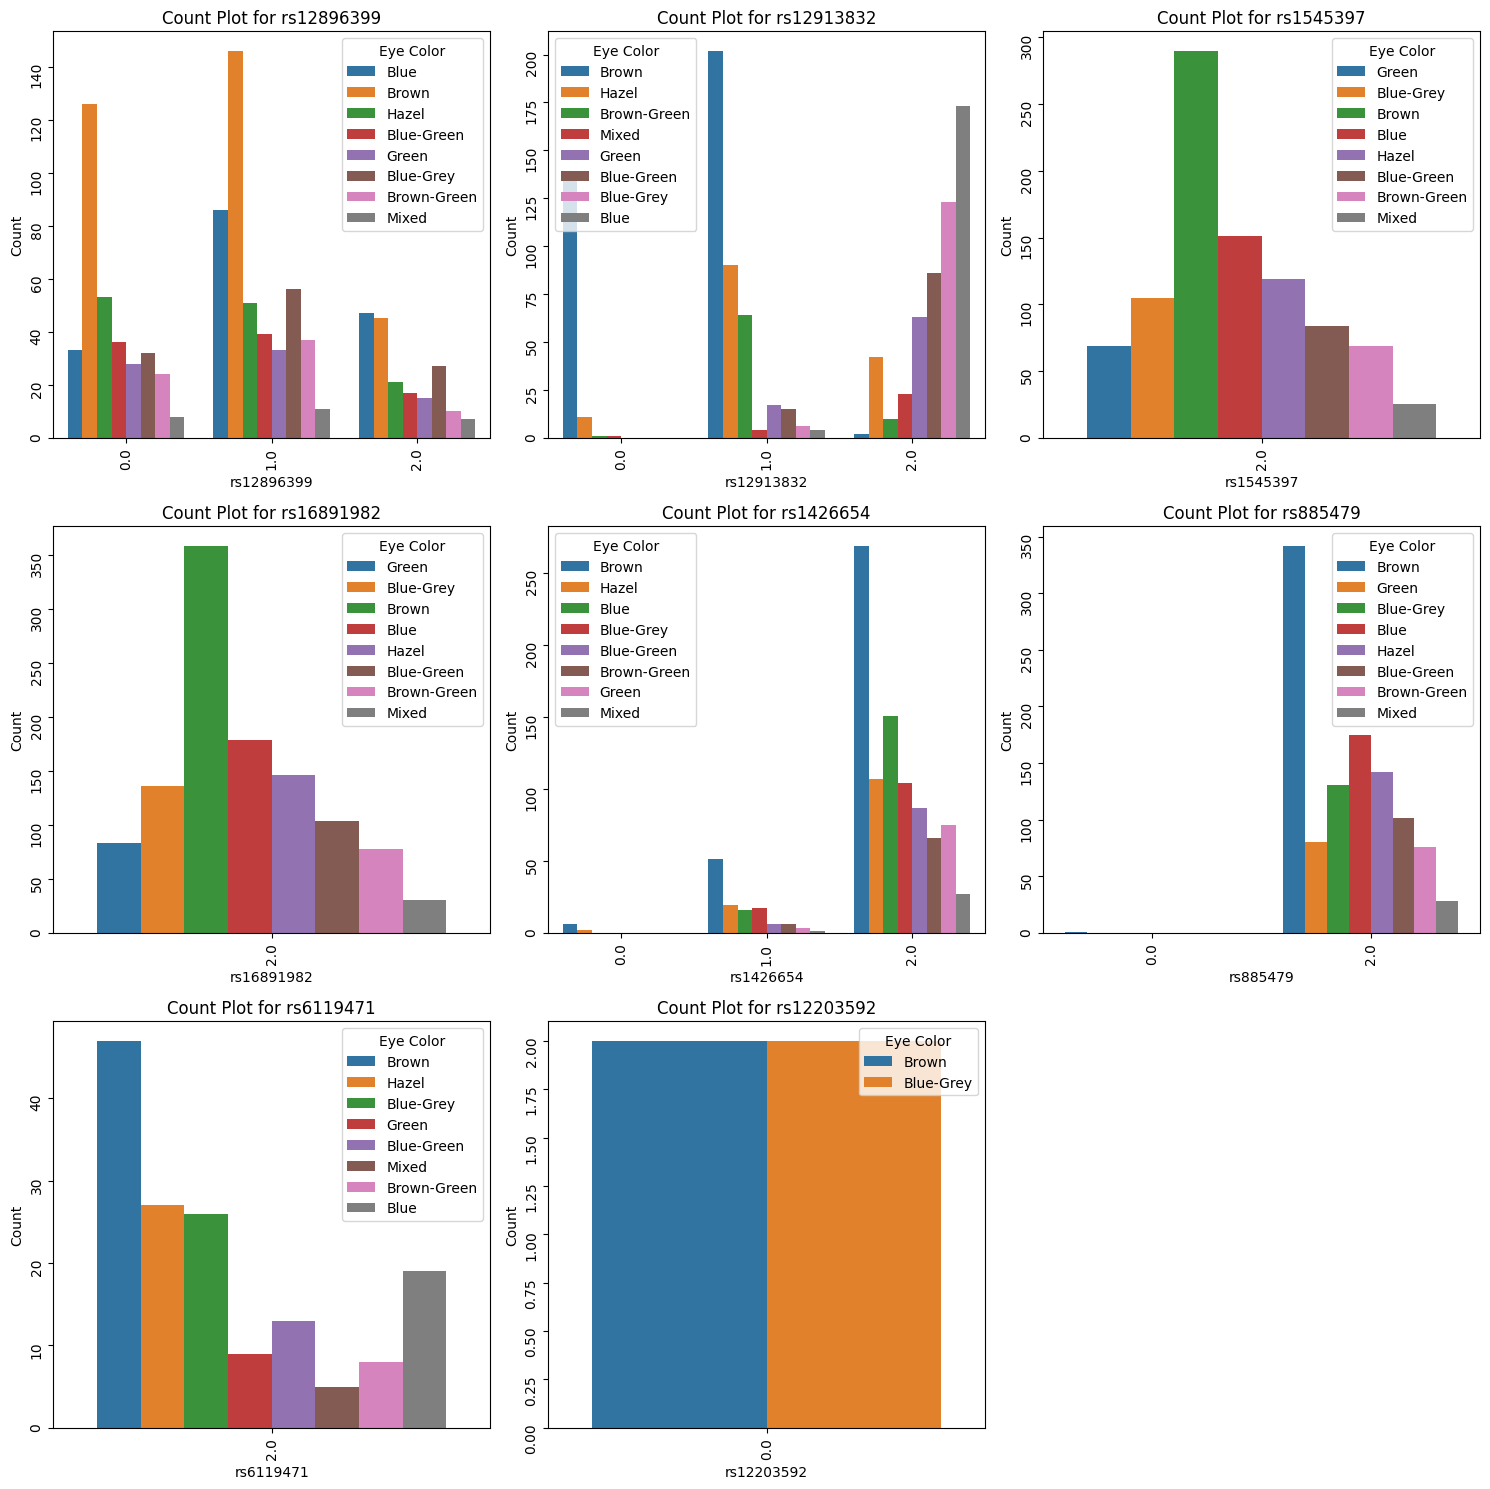

In [13]:
plot_rsin_eyecolor(df_encoded)


The plots show the genotype distribution across different eye colors for specific SNPs. For classification, SNPs with a diverse distribution of genotypes across eye colors (indicating a potential association between the SNP and eye color variation) should be retained. Columns 'rs12203592' and 'rs6119471', which show little to no variation in genotype across different eye colors and a high number of NaNs, might be less informative and should be dropped to simplify the model and potentially improve performance.

# Preprocessing

There are two ways to treat the remaining NaN vlaues. First we can introduce a fourth category ('3') in our features that encodes all NaN values. Second, we can think about a strategy to impute all NaN values. Here we have decided to drop all NaN values.

In [14]:
df = pd.read_csv(DATA["PREPROCESSED"])
df

,rs12896399,rs12913832,rs1545397,rs16891982,rs1426654,rs885479,eye_color
0,1.0,2.0,2.0,2.0,2.0,2.0,5
1,1.0,2.0,2.0,2.0,2.0,2.0,2
2,1.0,1.0,2.0,2.0,2.0,2.0,5
3,1.0,1.0,2.0,2.0,2.0,2.0,3
4,1.0,0.0,2.0,2.0,2.0,2.0,3
...,...,...,...,...,...,...,...
1124,3.0,3.0,3.0,2.0,2.0,3.0,2
1125,3.0,3.0,3.0,2.0,2.0,3.0,0
1126,3.0,3.0,3.0,2.0,2.0,3.0,3
1127,3.0,3.0,3.0,3.0,2.0,3.0,5


This is the dataset with all NaN values encoded as 3.0

In [15]:
df_no_na = pd.read_csv(DATA["PREPROCESSED_NO_NAN"])
print(f"Number of data points after removing NaNs: {df_no_na.shape[0]}")
df_no_na.head()

Number of data points after removing NaNs: 889


,rs12896399,rs12913832,rs1545397,rs16891982,rs1426654,rs885479,eye_color
0,1.0,2.0,2.0,2.0,2.0,2.0,5
1,1.0,2.0,2.0,2.0,2.0,2.0,2
2,1.0,1.0,2.0,2.0,2.0,2.0,5
3,1.0,1.0,2.0,2.0,2.0,2.0,3
4,1.0,0.0,2.0,2.0,2.0,2.0,3


This is the dataset after removing all NaN. Notice that this yields a dataset with only 889 data points compared to the 1129 from before.

# Final dataset

Finally, we one-hot encode the features. Here is the final dataset for the version in which we encoded the NaN values.

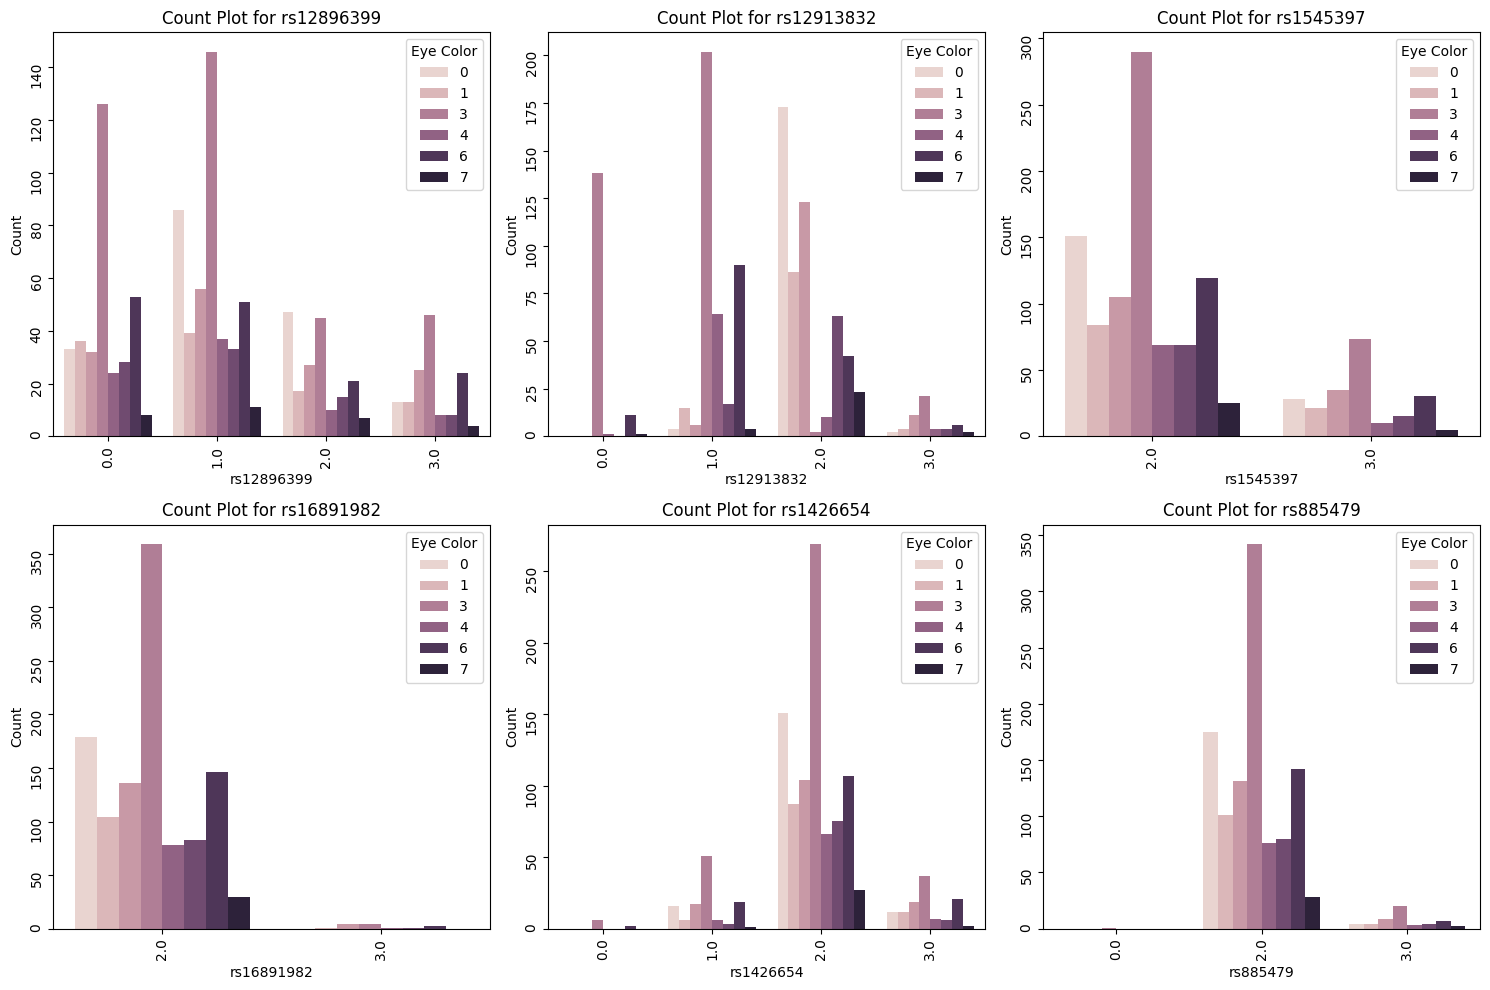

In [16]:
plot_rsin_eyecolor(df)

In [17]:
df = pd.read_csv(DATA["FINAL"])
df.isna().sum()

eye_color         0
rs12896399_1.0    0
rs12896399_2.0    0
rs12896399_3.0    0
rs12913832_1.0    0
rs12913832_2.0    0
rs12913832_3.0    0
rs1545397_3.0     0
rs16891982_3.0    0
rs1426654_1.0     0
rs1426654_2.0     0
rs1426654_3.0     0
rs885479_2.0      0
rs885479_3.0      0
dtype: int64

In [24]:
df.shape

(1129, 14)

No NaN values remaining

In [23]:
df.head()

,eye_color,rs12896399_1.0,rs12896399_2.0,rs12896399_3.0,rs12913832_1.0,rs12913832_2.0,rs12913832_3.0,rs1545397_3.0,rs16891982_3.0,rs1426654_1.0,rs1426654_2.0,rs1426654_3.0,rs885479_2.0,rs885479_3.0
0,5,True,False,False,False,True,False,False,False,False,True,False,True,False
1,2,True,False,False,False,True,False,False,False,False,True,False,True,False
2,5,True,False,False,True,False,False,False,False,False,True,False,True,False
3,3,True,False,False,True,False,False,False,False,False,True,False,True,False
4,3,True,False,False,False,False,False,False,False,False,True,False,True,False


# Model evaluation

## Weighted vs unweighted

In [25]:
# Read EVALUATION["METRICS"] into a dataframe
df_metrics = pd.read_json(EVALUATION["METRICS"])

# Read EVALUATION["METRICS_UNWEIGHTED"] into a dataframe
df_metrics_unweighted = pd.read_json(EVALUATION["METRICS_WEIGHTED"])

# Select the desired columns from both dataframes
df_selected_columns = pd.concat([df_metrics[['LINEAR_NO_NAN', 'LINEAR_ENCODED']],
                                 df_metrics_unweighted[['LINEAR_NO_NAN', 'LINEAR_ENCODED']]], axis=1)

# Append '_WEIGHTED' to the column names from EVALUATION["METRICS_UNWEIGHTED"]
df_selected_columns.columns = [col + '_WEIGHTED' if col in df_metrics_unweighted.columns else col for col in df_selected_columns.columns]

# Print the resulting dataframe
df_selected_columns


,LINEAR_NO_NAN_WEIGHTED,LINEAR_ENCODED_WEIGHTED,LINEAR_NO_NAN_WEIGHTED,LINEAR_ENCODED_WEIGHTED
train_loss,1.518222,1.543067,1.524288,1.615654
test_loss,1.584855,1.594012,1.566488,1.639377
test_acc,0.280899,0.358407,0.314607,0.336283
test_aucroc,0.741823,0.760394,0.748918,0.775206


But having trained both, the unweighted and weighted dataset in a logistic regression, we can see that weighting significantly decreases model performance.

## Encoding NaN vs. Droping NaN

## Model comparison

In [46]:
metrics_df = pd.read_json(EVALUATION['METRICS'])
metrics_df.head()

,LINEAR_NO_NAN,XGBOOST_NO_NAN,XGBOOST_FINE_NO_NAN,NEURAL_NETWORK_NO_NAN,LINEAR_NO_NAN_WEIGHTED,XGBOOST_NO_NAN_WEIGHTED,XGBOOST_FINE_NO_NAN_WEIGHTED,LINEAR,XGBOOST,XGBOOST_FINE,NEURAL_NETWORK
train_loss,1.309477,1.277684,1.317978,1.556957,1.405557,1.277684,1.330133,1.281021,1.236542,1.297685,1.530709
test_loss,1.250054,1.266503,1.300959,1.330563,1.340919,1.266503,1.308892,1.412259,1.448959,1.402736,1.432004
test_acc,0.514451,0.526012,0.537572,0.537572,0.433526,0.526012,0.537572,0.472727,0.463636,0.468182,0.477273
test_aucroc,0.799411,0.788173,0.777504,Not available,0.792887,0.788173,0.776622,0.753108,0.731958,0.755326,Not available


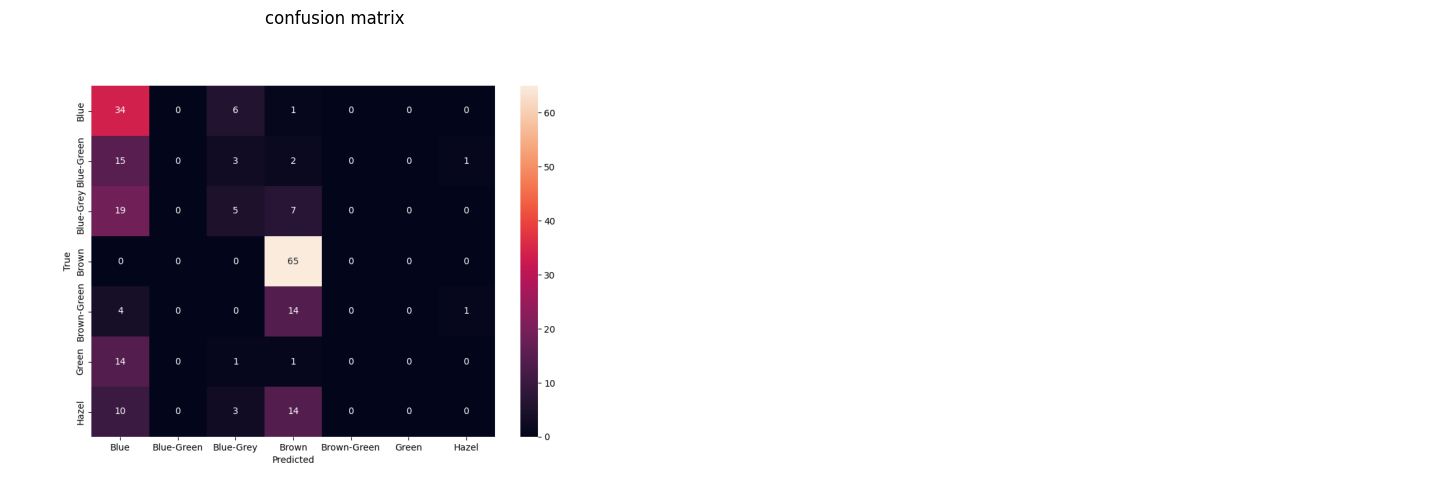

In [47]:
plot_images(EVALUATION["LINEAR"])

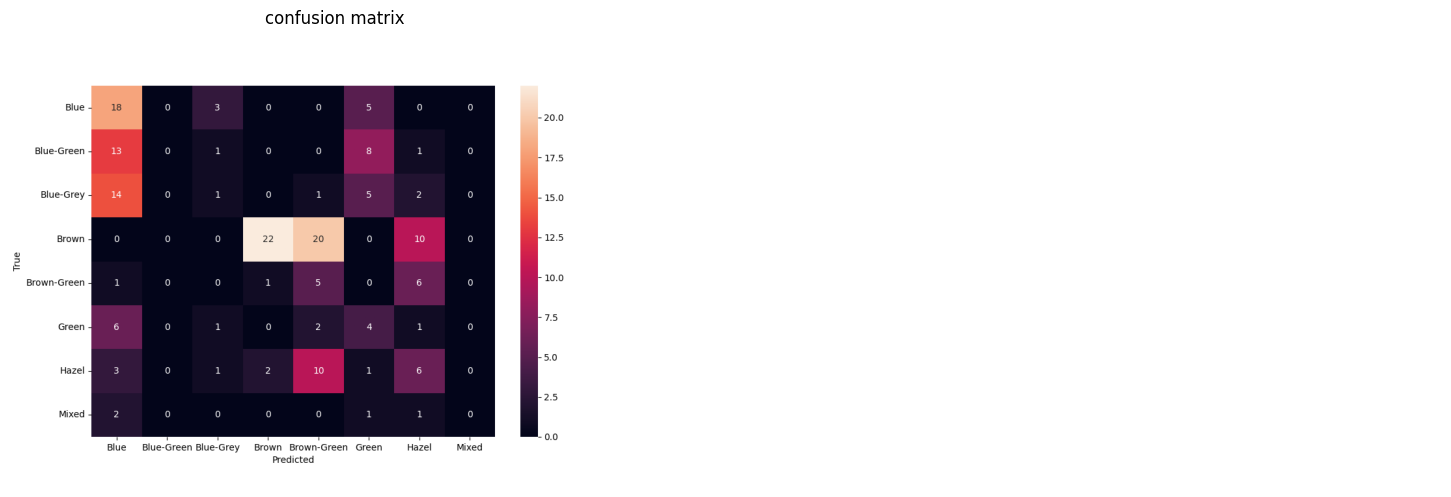

In [21]:
plot_images(EVALUATION["LINEAR_NO_NAN"])

# Explainability and Interpretability

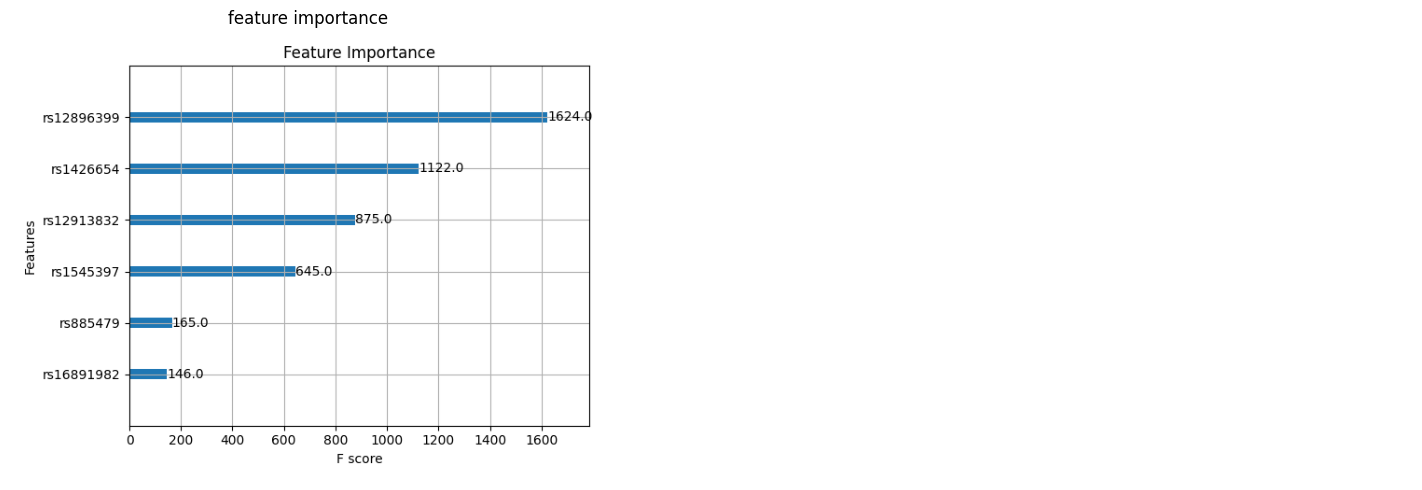

In [22]:
plot_images(EVALUATION["XGBOOST"])

# To go further
- Feature engineering: It could be beneficial for the model to add some more features such as: (1) Which allele matches reference? Maternal or Paternal allele? (2) Sex of the person
- Gather more data: Eyecolor is a polygenic gene. That means not only one but the combination of many loci is repsonsible for the final eye-color variation. Thus, collecting extensive data for all relelvant SNP is expected to increase model performance. Morevover, having more data samples in general will also help the model to generalize better. Especially in case we can find data balanced across target variables.
- Increase data quality: As it is often the case in open source datasets, the cluster is of mediocre quality which hampens model performance. For instance, the target, eye color, is described very inconsistently which can lead to missclassification.